### This notebook estimates the width of the Starlink satellites trails that corresponds to a fraction of the sky brightness, as a function of mirror diameter
* We assume a satellite is at 550km height, and 40 degree off zenith. The angular velocity is about 0.5 deg/sec.
* Because the satellites are at finite distances from the observatory, the FWHM of the trail is estimated as the following -

    FWHM = $\sqrt{\frac{D_{sat}^2}{d^2} + \frac{D_{pupil}^2}{d^2} + \theta_{atm}^2}$, 
    
    where $D_{sat} \sim$ 2m is the size of the satellite,
    $d$ = 550km/cos(zenith angle) is the distance from the observatory to the satellite, and
    $\theta_{atm}$ = 0.7 arcsec is the LSST seeing.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import PhotometricParameters, Sed
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from lsst.utils import getPackageDir 
from LEOSat import getSatSIIvonK, findWidth

In [2]:
angularV = 0.5*60 # in deg/min, 0.5 deg/sec, for 40 degree zenith angle, and satellite orbit going through zenith

#### We use Eq (6) in LSE-40. With the baseline system as defined by syseng_throughput (including hardware & atmosphere), We can easily map a source magnitude to a source count. 

In [3]:
# full_well for a 30s visit, in e-
noiseThresh = 0.3 #0.3 means trailCount < 0.3 * sqrt(skyCount), see 7/7/20 email to ZI and TT.
full_well = 150e3  #typical for e2v sensors. ITL is typically 200k. We try to be conservative and use the smaller.
full_well2 = 100e3  #some sensors can be as low as 100K e-.
xtalk_limit = 10e3 

#### We first determine what fraction of the flux will be in the center/brightest pixel

In [4]:
#Assume it moves along pixel grid. The time its image center moves from one pixel center to the next is dt
dt = 0.2/(angularV/60*3600) # in seconds

In [5]:
#satellite parameters
l1 = 2 #5 #2 #1.5 #meter
l2 = 2 #5 #2 #meter
h = 550e3

### Baseline LSST system, as defined in syseng_throughput

In [6]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

### Default photometric parameters, as used in standard m5 calculations

In [7]:
exptime=15 
nexp=2
readnoise=8.8 
othernoise=0 
darkcurrent=0.2
X=1.0

focalLength=10.3
pixel_size = 10 #micron
plate_scale = 0.2
e = 0.61
seeing = 0.7
zangle = 40

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
colors = ['blue', 'green', 'red', '0.75', '0.50', '0.25']

In [11]:
def func_powerlaw(x, w0, n):
    return w0*(x/8.36)**n

u, 112, 1, 8.425e-04, 3.193
g, 403, 4, 5.281e-04, 3.679
r, 329, 8, 9.142e-04, 3.118
i, 250, 12, 1.440e-03, 2.741
z, 173, 18, 2.560e-03, 2.347
y, 83, 24, 6.136e-03, 1.858


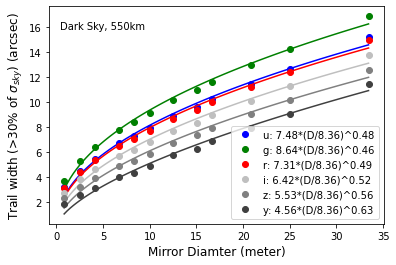

In [22]:
mag = 7 #4.5
myfs = [0.1,0.3,0.5, 0.8, 1, 1.2, 1.5, 1.8, 2.0, 2.5, 3, 4] #np.linspace(0.1,3,10) #[1,2,3] #
fig, ax = plt.subplots()
for i,f in enumerate(filterlist): # enumerate(('u','g')):  #
    widths = []
    ds = []
    for myf in myfs:
        d=8.36*myf
        ds.append(d)
        [sii, fwhm_exp] = getSatSIIvonK(focalLength,d,e, l1, l2, h, zangle, seeing, pixel_size, plate_scale)

        cs = np.sum(sii,axis=0) #cross section
        idx = np.argmax(cs==max(cs))
        pRatio = sum(cs[idx-1:idx+2])/0.21*0.2
        # print('peak pixel flux/total flux = %.4f'%pRatio)
        # PhotometricParameters object for standard m5 calculations.
        effarea=np.pi*(myf*6.423/2*100)**2
        photParams_std = PhotometricParameters(exptime=exptime, nexp=nexp,
                                               gain=1.0, effarea=effarea, readnoise=readnoise,
                                               othernoise=othernoise, darkcurrent=darkcurrent)
        m5 = st.makeM5(hardware, system, darksky=None, 
                          exptime=exptime, nexp=nexp, readnoise=readnoise, othernoise=othernoise, darkcurrent=darkcurrent,
                          effarea=effarea, X=1.0)

        # change exposure to dt
        photParams_dt = PhotometricParameters(exptime=dt, nexp=1,
                                               gain=1.0, effarea=effarea, readnoise=readnoise,
                                               othernoise=othernoise, darkcurrent=darkcurrent)
        

        flatsource = Sed()
        flatsource.setFlatSED(wavelen_min=system[f].wavelen_min, wavelen_max=system[f].wavelen_max,
                              wavelen_step=system[f].wavelen_step)
        adu = flatsource.calcADU(system[f], photParams=photParams_dt)
        
        nSat = adu*10**(-mag/2.5)
        npeak = nSat*pRatio + m5.skyCounts[f]
        if npeak>full_well2:
            width = np.nan
        else:
            width = findWidth(cs, noiseThresh*np.sqrt(m5.skyCounts[f])/20*7/nSat)*0.07    #each pixel is 0.07"
            #width = findWidth(cs, 10/20*7/nSat)*0.07    #each pixel is 0.07"
        if myf == myfs[0]:
            print('%s, %.0f, %.0f, %.3e, %.3f'%(f, nSat, m5.skyCounts[f],noiseThresh*np.sqrt(m5.skyCounts[f])/20*7/nSat, width))
        widths.append(width)
    #aa = np.polyfit(ds, widths,1)
    #ww = aa[1]+aa[0]*np.array(ds)
    ds = np.array(ds)
    widths = np.array(widths)
    idx = ~np.isnan(widths)
    popt, pcov = curve_fit(func_powerlaw, ds[idx], widths[idx])
    bb = np.linspace(min(ds), max(ds),100)
    plt.plot(bb, func_powerlaw(bb, *popt), '-', color=colors[i])
    plt.plot(ds, widths, 'o', label='%s: %.2f*(D/8.36)^%.2f'%(f,popt[0], popt[1]), color=colors[i])
    #break
plt.legend(loc='lower right')
plt.text(0.15, 0.8, "Dark Sky, 550km", color = 'black', transform=fig.transFigure)
plt.xlabel('Mirror Diamter (meter)', fontsize=12)
plt.ylabel(r'Trail width (>%.0f%% of $\sigma_{sky}$) (arcsec)'%(noiseThresh*100), fontsize=12)
plt.savefig('width_vs_Dmirror.pdf')